In [56]:
# Parameters
experiment_config_path = None
experiment_output_dir = None
apartment_initial_conditions = None
na_growth_rate_fill_value = None

In [6]:
# # Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/experiment_example_G3.yaml'
# experiment_output_dir = '/lab/data/celldom/output/20180923-G3-full'
# apartment_initial_conditions = ['single_cell']

In [7]:
assert experiment_config_path, 'Must provide value for parameter `experiment_config_path`'
assert experiment_output_dir, 'Must provide value for parameter `experiment_output_dir`'

if str(apartment_initial_conditions) == 'None':
    apartment_initial_conditions = None    
elif isinstance(apartment_initial_conditions, str):
    apartment_initial_conditions = [apartment_initial_conditions]

if str(na_growth_rate_fill_value) == 'None':
    na_growth_rate_fill_value = None
else:
    na_growth_rate_fill_value = float(na_growth_rate_fill_value)

In [8]:
%matplotlib inline
import celldom
import os
import os.path as osp
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from skimage import io
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import calculation

In [9]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)

In [10]:
# For this part of the analysis, assume that we want to examine growth rates in all
# apartments regardless of their initial conditions
print(
    'Apartment initial condition filter update: {} -> {}'.format(
        config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter'],
        apartment_initial_conditions
    )
)
config.get_analysis_config()['apartment_growth_rate']['initial_conditions_filter'] = apartment_initial_conditions

Apartment initial condition filter update: ['single_cell', 'double_cell'] -> ['single_cell']


In [11]:
# Fetch apartment growth rate data (this may take a minute or two)
df = calculation.calculate_apartment_growth_rates(experiment, save=False)
df = calculation.remove_oob_apartments(experiment, df)
df['array'] = df[config.experimental_condition_fields].apply(':'.join, axis=1)

# Apply NA growth rate placeholder, if provided
if na_growth_rate_fill_value is not None:
    df['growth_rate'] = df['growth_rate'].fillna(na_growth_rate_fill_value)
    
# Ignore invalid growth rates (Note that the fill value above provides a way to distinguish
# between apartments with no data and apartments with conditions ineligible for growth rate calculation)
df = df[df['growth_rate'].notnull()]

df.info()

Using conditions filter:  ['single_cell']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15582 entries, 0 to 15639
Data columns (total 20 columns):
acq_pump             15582 non-null object
acq_color            15582 non-null object
acq_condition        15582 non-null object
acq_cohort           15582 non-null object
st_num               15582 non-null object
apt_num              15582 non-null object
acq_ids              15582 non-null object
cell_counts          15582 non-null object
confluence           15582 non-null object
elapsed_hours_min    15582 non-null float64
first_count          15582 non-null float64
first_date           15582 non-null datetime64[ns]
growth_rate          9353 non-null float64
last_count           15582 non-null float64
last_date            15582 non-null datetime64[ns]
max_cell_count       15582 non-null float64
min_cell_count       15582 non-null float64
n                    15582 non-null int64
occupancies          15582 non-null object
array       

In [12]:
df['growth_rate'].describe()

count    9353.000000
mean        0.168386
std         0.314040
min        -0.714454
25%        -0.012958
50%         0.125585
75%         0.306234
max         1.465544
Name: growth_rate, dtype: float64

## Array Heatmap Visualization

/usr/local/lib/python3.5/dist-packages/mizani/bounds.py:345: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/usr/local/lib/python3.5/dist-packages/mizani/bounds.py:345: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


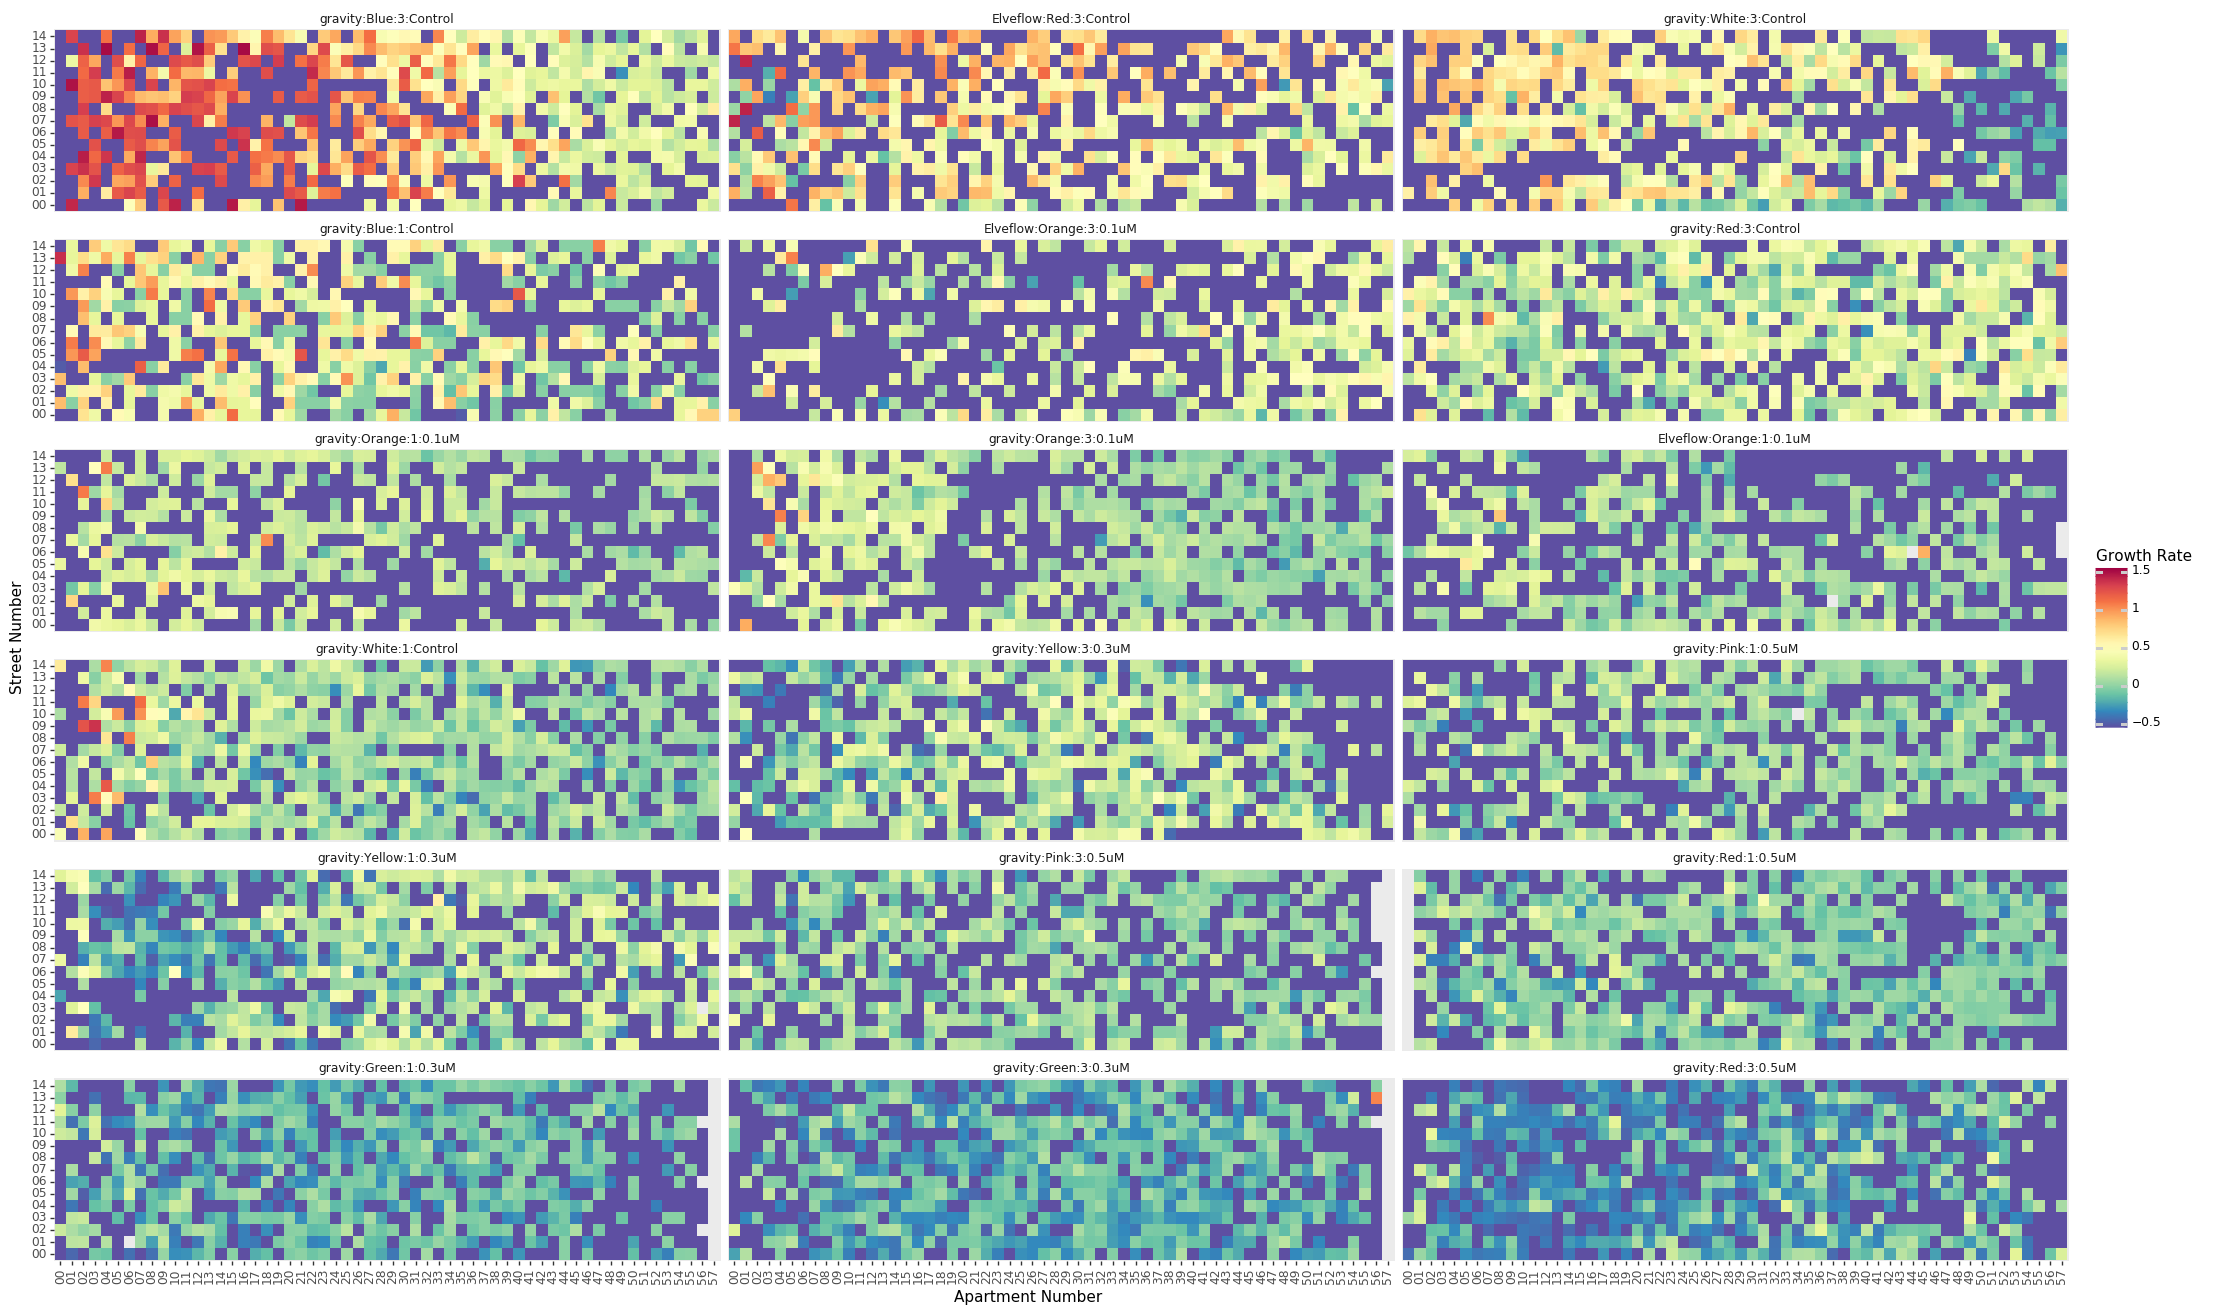

<ggplot: (-9223363305201333707)>

In [17]:
(
    pn.ggplot(
        (
            df
            .assign(array=pd.Categorical(
                df['array'], ordered=True,
                categories=df.groupby('array')['growth_rate'].mean().sort_values(ascending=False).index
            ))
            .rename(columns={'growth_rate': 'Growth Rate'})
        ), 
        pn.aes(x='apt_num', y='st_num', fill='Growth Rate')
    ) +
    pn.geom_tile() +
    pn.scale_fill_cmap(name='Spectral_r', limits=(-.5, 1.5)) +#, guide=pn.guide_legend(title='Growth Rate')) +
    pn.facet_wrap('~array', ncol=3) +
    pn.xlab('Apartment Number') +
    pn.ylab('Street Number') +
    pn.theme(
        figure_size=(26,16),
        axis_text_x=pn.element_text(rotation=90, hjust=.5),
        panel_grid_major=pn.element_blank(),
        panel_grid_minor=pn.element_blank(),
        strip_background=pn.element_rect(fill="white")
    )
)